# Parte A

______

Colunas do Dataset:
- Column1: Device ID
- Column2: accelerometer x
- Column3: accelerometer y
- Column4: accelerometer z
- Column5: gyroscope x
- Column6: gyroscope y
- Column7: gyroscope z
- Column8: magnetometer x
- Column9: magnetometer y
- Column10: magnetometer z
- Column11: Timestamp
- Column12: Activity Label (16 atividades)


Importar as livrarias-chave

In [197]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math

# importar livraria que contem as funcoes das features
import featuresFunctions

matplotlib.rcParams['figure.figsize'] = [30, 20]
import warnings
warnings.filterwarnings("ignore")

# 2. Carregamento e preparação dos dados

In [198]:
loc = []

for i in range (0,15):
    loc.append("FORTH_TRACE_DATASET-master/part" + str(i) + "/part" + str(i) + "dev2.csv")

array = []
for file in loc:
    df = pd.read_csv(file, sep=',', header=None)
    array.append(df.to_numpy())

array = np.concatenate(array)
print(array.shape)

(781822, 12)


# 3. Análise e tratamento de *Outliers*

Criar os np.arrays dos módulos dos vetores aceleração, giroscópio e magnetómetro

In [199]:

t_acc = np.sqrt(np.add(np.square(array[:,1]),
                       np.square(array[:,2]),
                       np.square(array[:,3])))

t_gyr = np.sqrt(np.add(np.square(array[:,4]),
                       np.square(array[:,5]),
                       np.square(array[:,6])))

t_mag = np.sqrt(np.add(np.square(array[:,7]),
                       np.square(array[:,8]),
                       np.square(array[:,9])))



## 3.1 boxplot de cada atividade

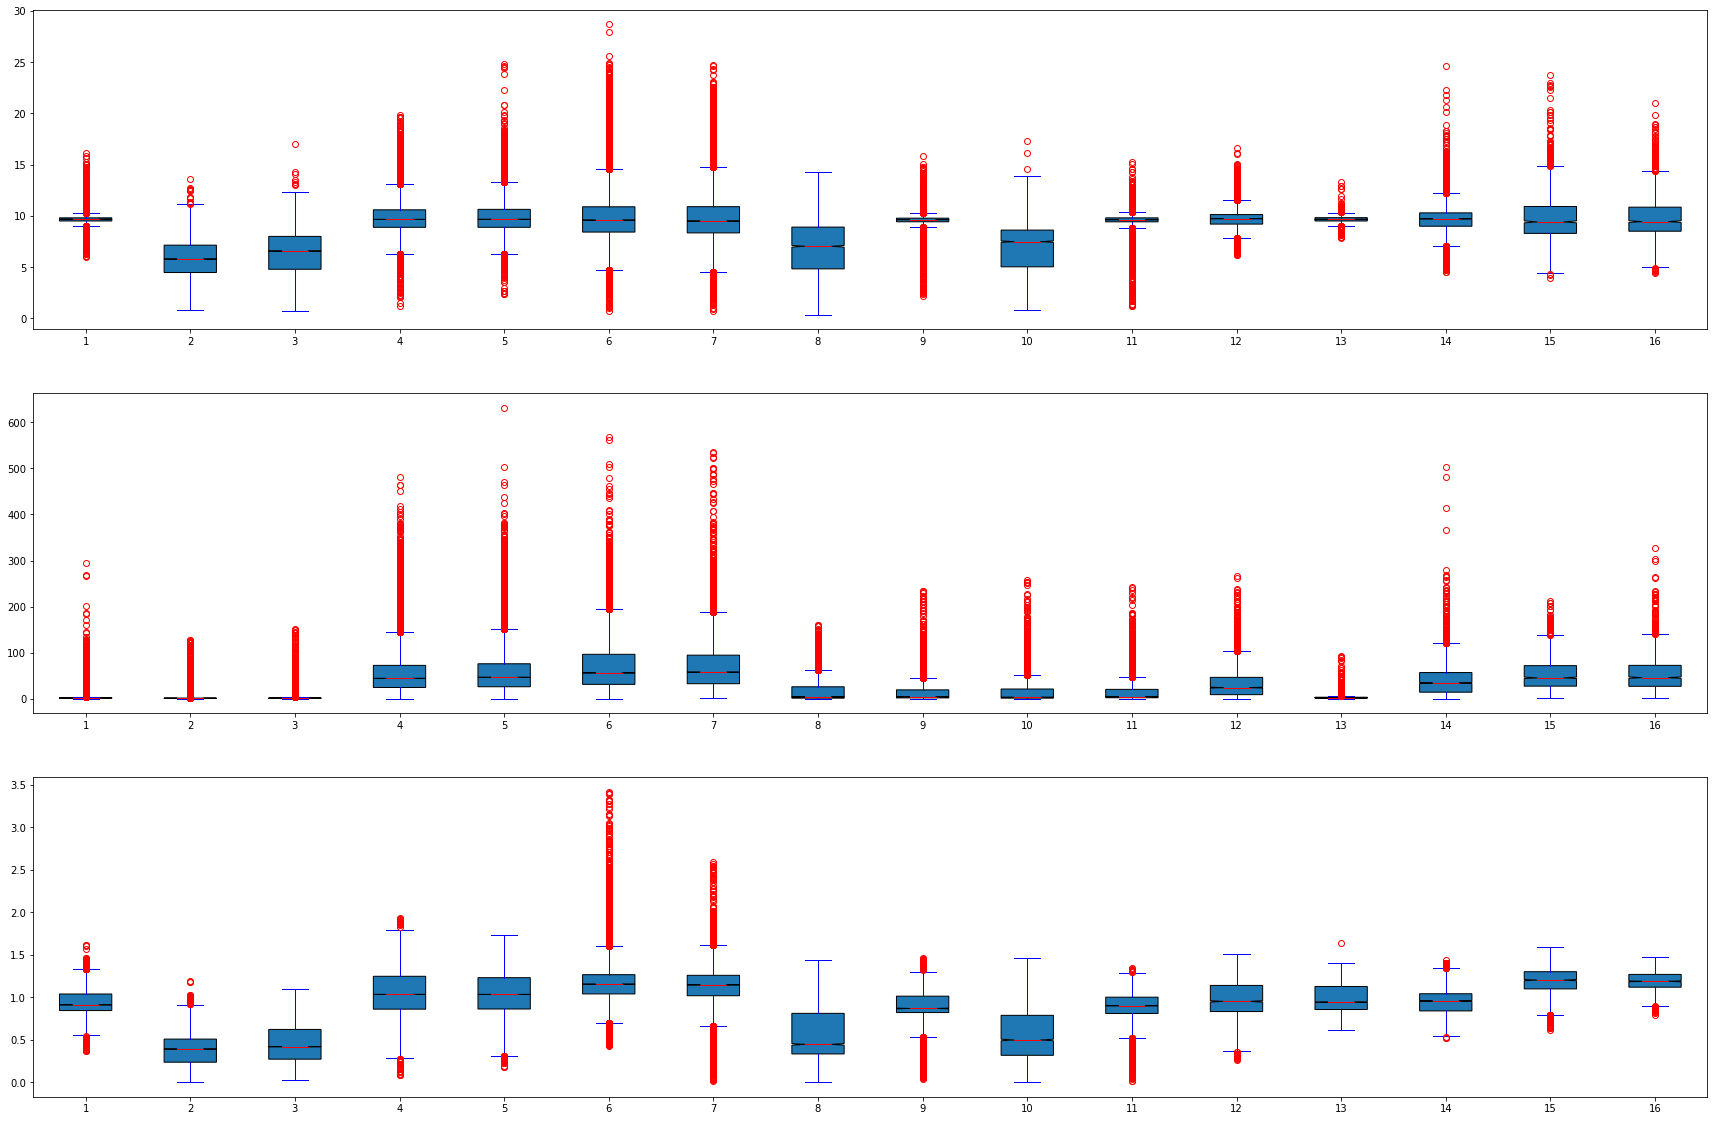

In [200]:

# act1 = t_acc[array[:,-1]==5]
activities = np.arange(1, 17) 
box_acc = [] # TODO ver se dá para fazer isto com np.array
box_gyr = []
box_mag = []
for i in range(1,17):
    act = (array[:,-1]==i)
    #length = np.sum(act)
    box_acc.append(t_acc[act]) 
    box_gyr.append(t_gyr[act])
    box_mag.append(t_mag[act])

c = "blue"
fig, axs = plt.subplots(3)
axs[0].boxplot(box_acc, notch=True, patch_artist=True,
            capprops=dict(color="blue"),
            whiskerprops=dict(color="blue"),
            flierprops=dict(color="red", markeredgecolor="red"),
            medianprops=dict(color="red"))
axs[1].boxplot(box_gyr, notch=True, patch_artist=True,
            capprops=dict(color="blue"),
            whiskerprops=dict(color="blue"),
            flierprops=dict(color="red", markeredgecolor="red"),
            medianprops=dict(color="red"))
axs[2].boxplot(box_mag, notch=True, patch_artist=True,
            capprops=dict(color="blue"),
            whiskerprops=dict(color="blue"),
            flierprops=dict(color="red", markeredgecolor="red"),
            medianprops=dict(color="red"))
plt.rcParams['figure.figsize'] = [30, 20]
plt.show()

## 3.2 Densidade de outliers

Densidade de outliers segundo o boxplot nos módulos dos vetores para cada atividade

<Figure size 2160x1440 with 0 Axes>

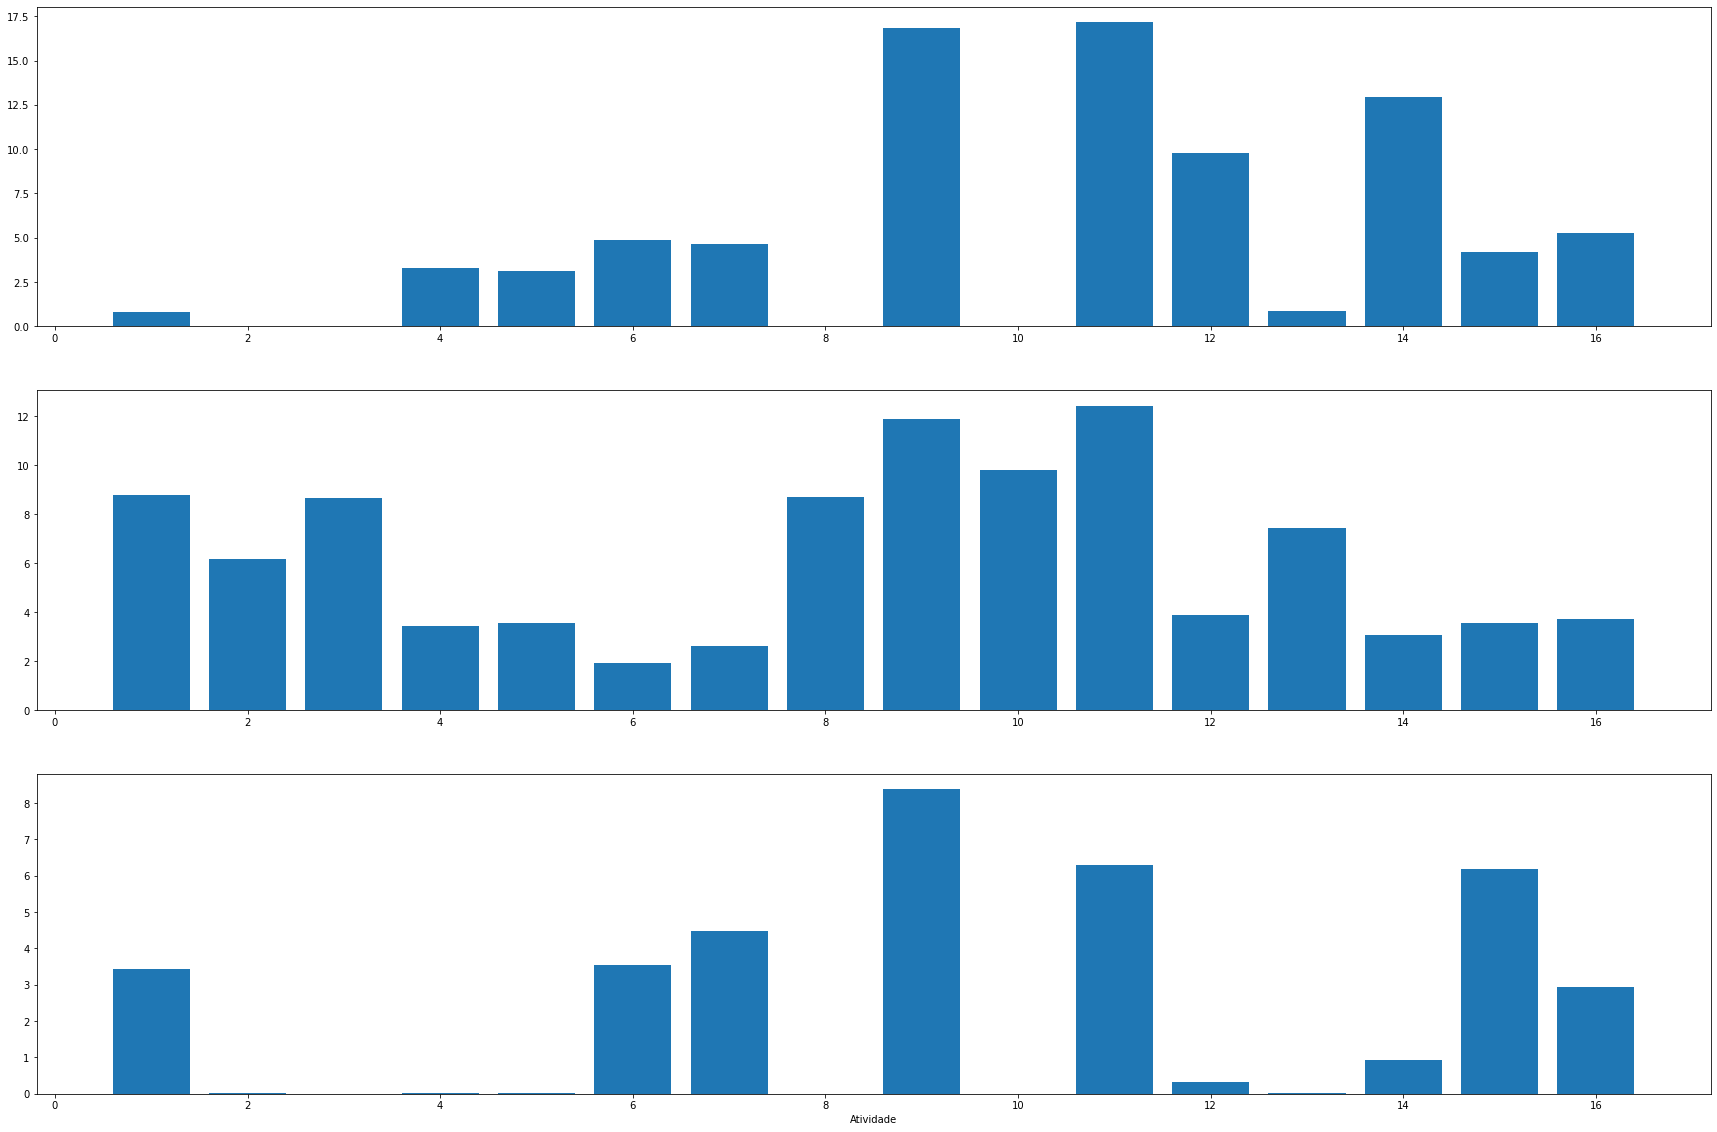

In [201]:
# desvio e outliers para cada k = 3, 3.5, 4
d = np.empty(shape=[3,16])
outliers = []
it = 0

# iterar pelos modulos e, depois, por cada atividade
for box in ([box_acc, box_gyr, box_mag]):
    
    for i in range(16):
        # computar os quartis e definir os limites
        q1 = np.quantile(box[:][i], 0.25)
        q3 = np.quantile(box[:][i], 0.75)
        iqr = q3-q1 
        upper_bound = q3+(1.5*iqr)
        lower_bound = q1-(1.5*iqr)

        # receber os outliers e a matrix de indices
        outliers.append(box[:][i][(box[:][i] < lower_bound) | (box[:][i] > upper_bound)])
        out_bool = (box[:][i] <= lower_bound) | (box[:][i] >= upper_bound)
        
        # densidade de outliers
        counts = np.count_nonzero(out_bool==True)
        d[it][i] = (counts/out_bool.size)*100 
    it+=1

xticks = np.linspace(1, 16, 16, endpoint=True)
plt.figure()
fig, axs = plt.subplots(3)
axs[0].bar(xticks, d[0])
axs[1].bar(xticks, d[1])
axs[2].bar(xticks, d[2])
plt.xlabel('Atividade')
plt.show()


Com uma análise superficial, rapidamente observa-se um pico claro em cada um dos módulos, em específico nas atividades 1, 2 e 1 de novo, respetivamente.

**TODO**

## 3.3 Função Z-score

In [202]:
def zscore(scores, k, axis=0):
    a = np.asanyarray(scores)
    if a.size == 0:
        return np.empty(a.shape)
    
    mn = np.mean(a, axis = axis)
    std = np.std(a, axis = axis)
    
    z = (scores - mn) / std
    outliers = scores[(z < -k) | (z > k)]
    
    return z, outliers


## 3.4 Teste de Z-score

<Figure size 2160x1440 with 0 Axes>

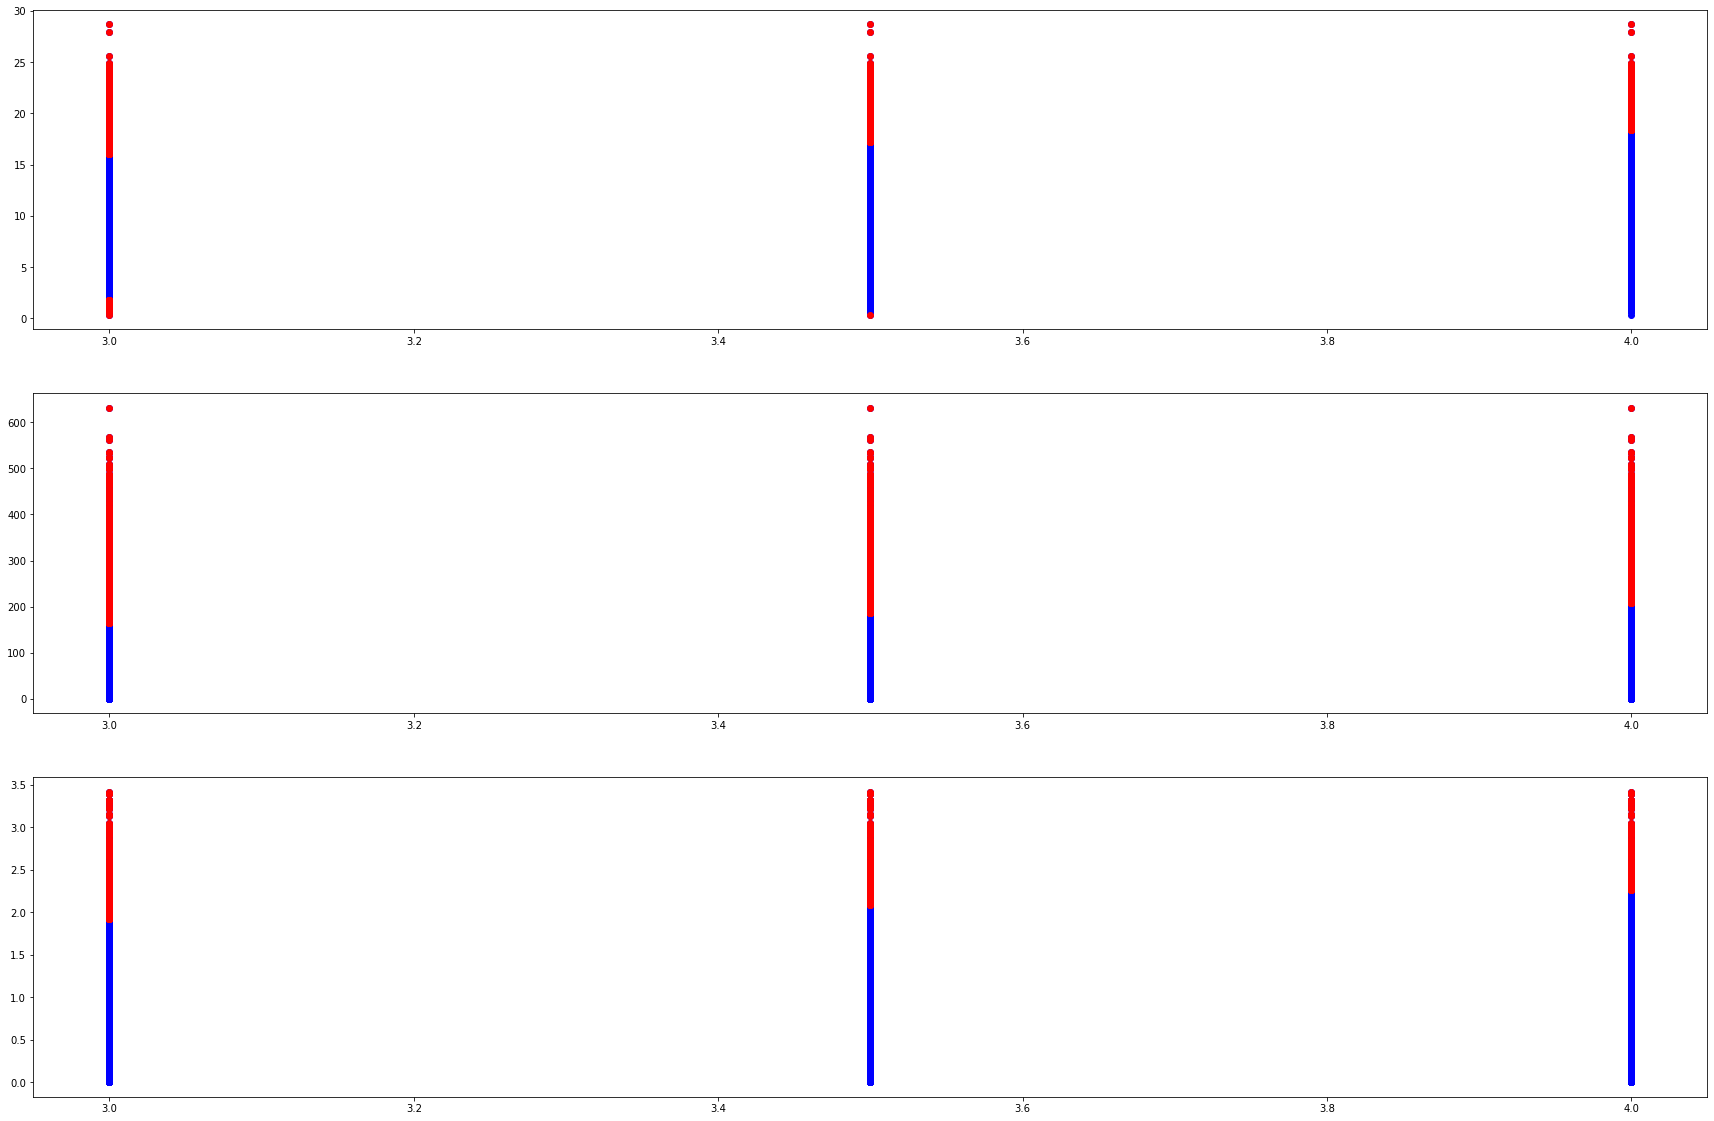

In [203]:
outliersk = []

for mod in [t_acc, t_gyr, t_mag]:
    z1, out1 = zscore(mod, 3)
    z2, out2 = zscore(mod, 3.5)
    z3, out3 =zscore(mod, 4)
    outliersk.append(out1)
    outliersk.append(out2)
    outliersk.append(out3)

uni_vec = np.ones(t_acc.shape)
fig = plt.figure()    
fig, axes = plt.subplots(nrows = 3, ncols = 1)
axes[0].scatter(uni_vec*3, t_acc, color="blue")
axes[0].scatter(np.ones(outliersk[0].shape)*3, outliersk[0], color="red")
axes[0].scatter(uni_vec*3.5, t_acc, color="blue")
axes[0].scatter(np.ones(outliersk[1].shape)*3.5, outliersk[1], color="red")
axes[0].scatter(uni_vec*4, t_acc, color="blue")
axes[0].scatter(np.ones(outliersk[2].shape)*4, outliersk[2], color="red")

axes[1].scatter(uni_vec*3, t_gyr, color="blue")
axes[1].scatter(np.ones(outliersk[3].shape)*3, outliersk[3], color="red")
axes[1].scatter(uni_vec*3.5, t_gyr, color="blue")
axes[1].scatter(np.ones(outliersk[4].shape)*3.5, outliersk[4], color="red")
axes[1].scatter(uni_vec*4, t_gyr, color="blue")
axes[1].scatter(np.ones(outliersk[5].shape)*4, outliersk[5], color="red")

axes[2].scatter(uni_vec*3, t_mag, color="blue")
axes[2].scatter(np.ones(outliersk[6].shape)*3, outliersk[6], color="red")
axes[2].scatter(uni_vec*3.5, t_mag, color="blue")
axes[2].scatter(np.ones(outliersk[7].shape)*3.5, outliersk[7], color="red")
axes[2].scatter(uni_vec*4, t_mag, color="blue")
axes[2].scatter(np.ones(outliersk[8].shape)*4, outliersk[8], color="red")

plt.show()

## 3.5 Comparar os resultados dos dois métodos

In [204]:
diff = np.empty(shape=[3,3])

print("           boxplot  z-score")
print("k={}".format(0))
print("mod. acc: {} {}".format(np.hstack(outliers[0:16]).shape, outliersk[0].shape))
print("mod. gyr: {} {}".format(np.hstack(outliers[16:32]).shape, outliersk[3].shape))
print("mod. mag: {} {}".format(np.hstack(outliers[32:48]).shape, outliersk[6].shape))

print("k={}".format(1))
print("mod. acc: {} {}".format(np.hstack(outliers[0:16]).shape, outliersk[1].shape))
print("mod. gyr: {} {}".format(np.hstack(outliers[16:32]).shape, outliersk[4].shape))
print("mod. mag: {} {}".format(np.hstack(outliers[32:48]).shape, outliersk[7].shape))

print("k={}".format(2))
print("mod. acc: {} {}".format(np.hstack(outliers[0:16]).shape, outliersk[2].shape))
print("mod. gyr: {} {}".format(np.hstack(outliers[16:32]).shape, outliersk[5].shape))
print("mod. mag: {} {}".format(np.hstack(outliers[32:48]).shape, outliersk[8].shape))



           boxplot  z-score
k=0
mod. acc: (19740,) (9235,)
mod. gyr: (42314,) (12856,)
mod. mag: (11700,) (350,)
k=1
mod. acc: (19740,) (1598,)
mod. gyr: (42314,) (6874,)
mod. mag: (11700,) (220,)
k=2
mod. acc: (19740,) (787,)
mod. gyr: (42314,) (3705,)
mod. mag: (11700,) (167,)


A análise feita baseia-se na quantidade de outliers registados em cada módulo do sensor. Na análise se cada atividade somou-se o número de ouliers em cada uma delas.

Verifica-se que o teste z-score retira muito menos outliers para cada um dos k testados (3, 3.5 e 4). Conincidem, então os outliers da periferia (mostrados a vermelhor no plot acima).

## 3.6 Implementar o algoritmo Kmeans


In [242]:
from numpy.linalg import norm

def get_centroids(data, clusters):
    if type(data) != np.ndarray:
        data = np.array(data)
    rand_id = np.random.permutation(data.shape[0])
    centroids = data[rand_id[:(clusters)]] # cria 3 centroides para cada coluna
    return centroids

def get_distance(data, centroids, clusters):
    distance = np.zeros((data.shape[0], clusters))
    for i in range(clusters):
        row_norm = norm(data - centroids[i], axis=1)
        distance[:, i] = np.square(row_norm)
    return distance

def compute_centroids(data, clusters, distance):
    centroids = np.zeros((clusters, data.shape[1]))
    arr_min = np.argmin(distance, axis=1)
    for k in range(clusters):
        centroids[k, :] = np.mean(data[arr_min == k], axis=0)
    return centroids

def k_means(data, clusters):
    '''
    accepts a np.array with shape (n, m) with m exists
    '''
    centroids = get_centroids(data, clusters)
    diff = 1
    while diff!=0:
        old_centroids = centroids
        distance = get_distance(data, old_centroids, clusters)
        centroids = compute_centroids(data, clusters, distance)
        diff = np.sum(np.subtract(centroids, old_centroids))
        dist = get_distance(data, centroids, clusters)
        cluster = np.argmin(dist, axis=1)
    return centroids, cluster



## 3.7 Outliers segundo Kmeans

In [243]:
from scipy.spatial.distance import cdist

K = range(1, 10)
distortions = []
clusters = []


for k in K:
    #kmeanModel = KMeans(n_clusters=k).fit(X)
    centroids, cluster = k_means(array[:,1:10], k)
    distortions.append(np.sum(np.min(cdist(array[:,1:10], centroids, 'euclidean'), axis=1)) / array[:,1:10].shape[0])
    clusters.append(cluster)   


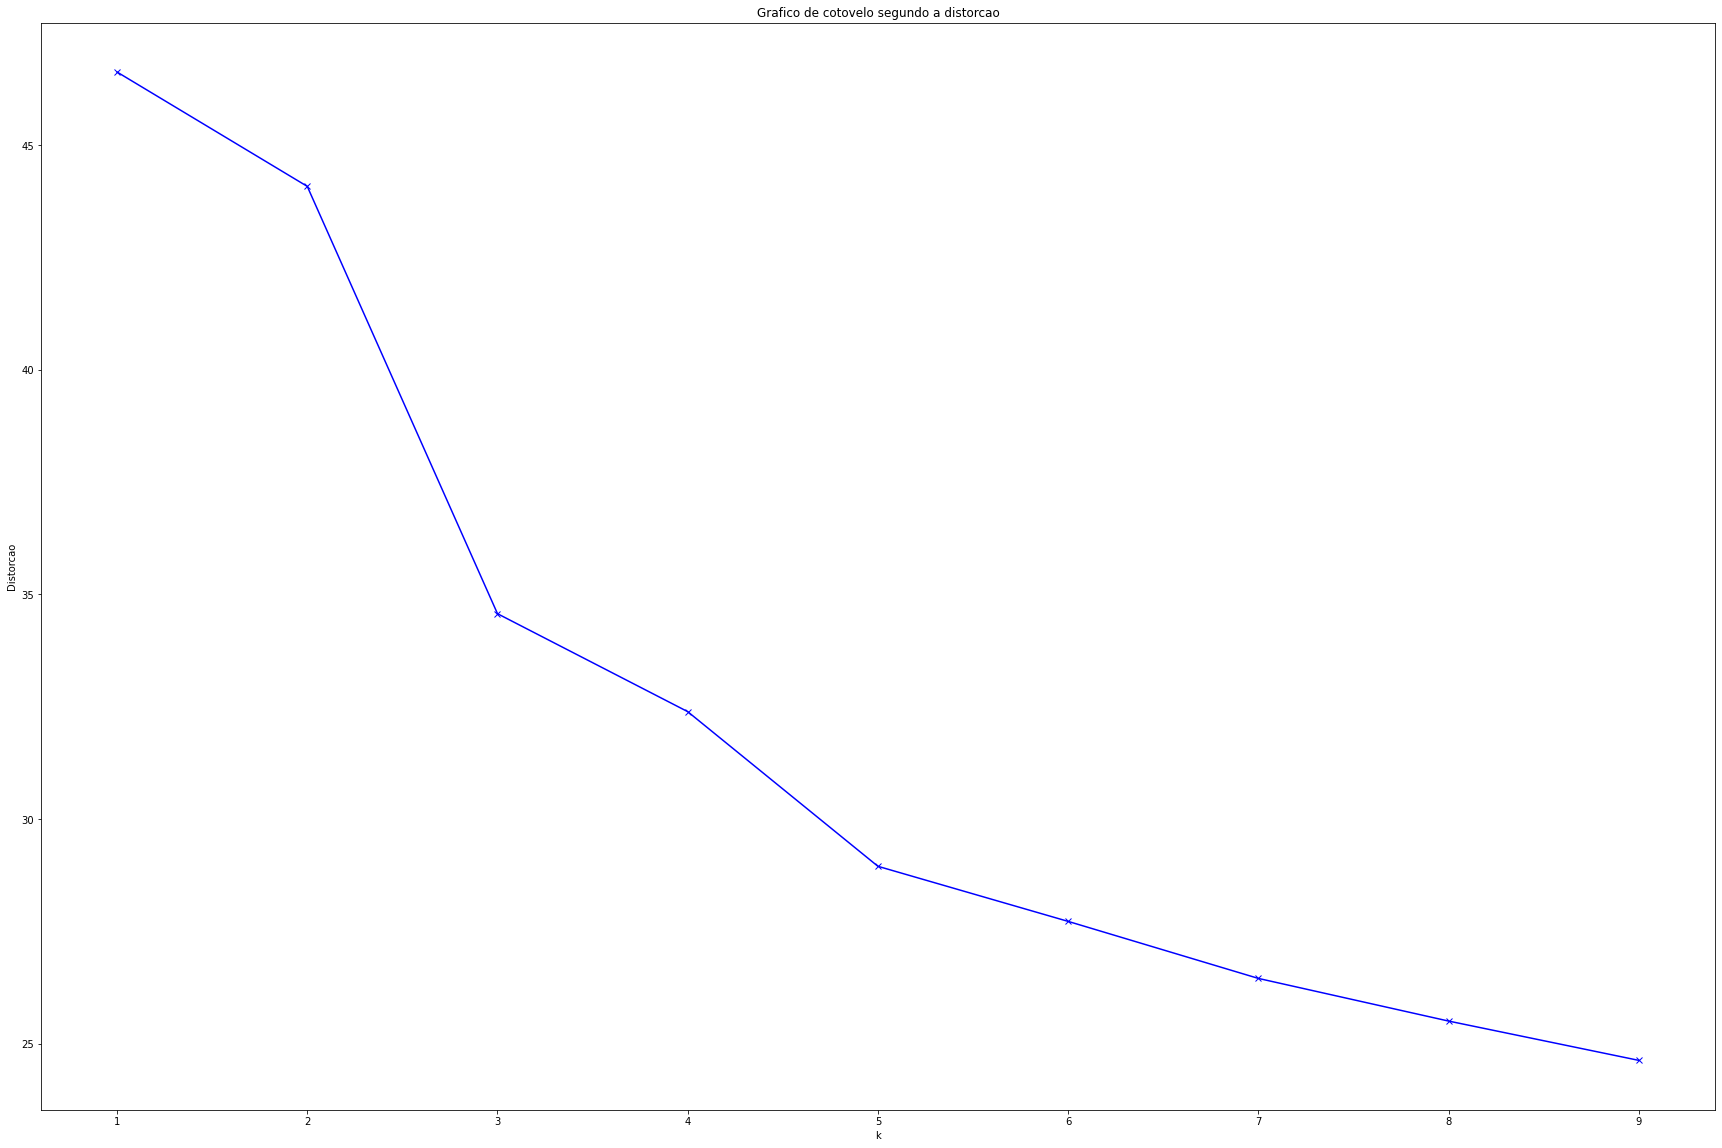

In [244]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorcao')
plt.title('Grafico de cotovelo segundo a distorcao')
plt.show()

Do "gráfico de cotovelo" retiramos que o melhor valor a utilizar será k=4. Deferimos este valor como o vértice do gráfico e o valor ideal, mesmo que a respresentação não seja a ideal.

Retirar os indices para os clusters

In [246]:
k=4
unique, counts = np.unique(clusters[k-1], return_counts=True)
ind = [] 

for n in unique:
    ind.append(np.where(clusters[k-1]==n))

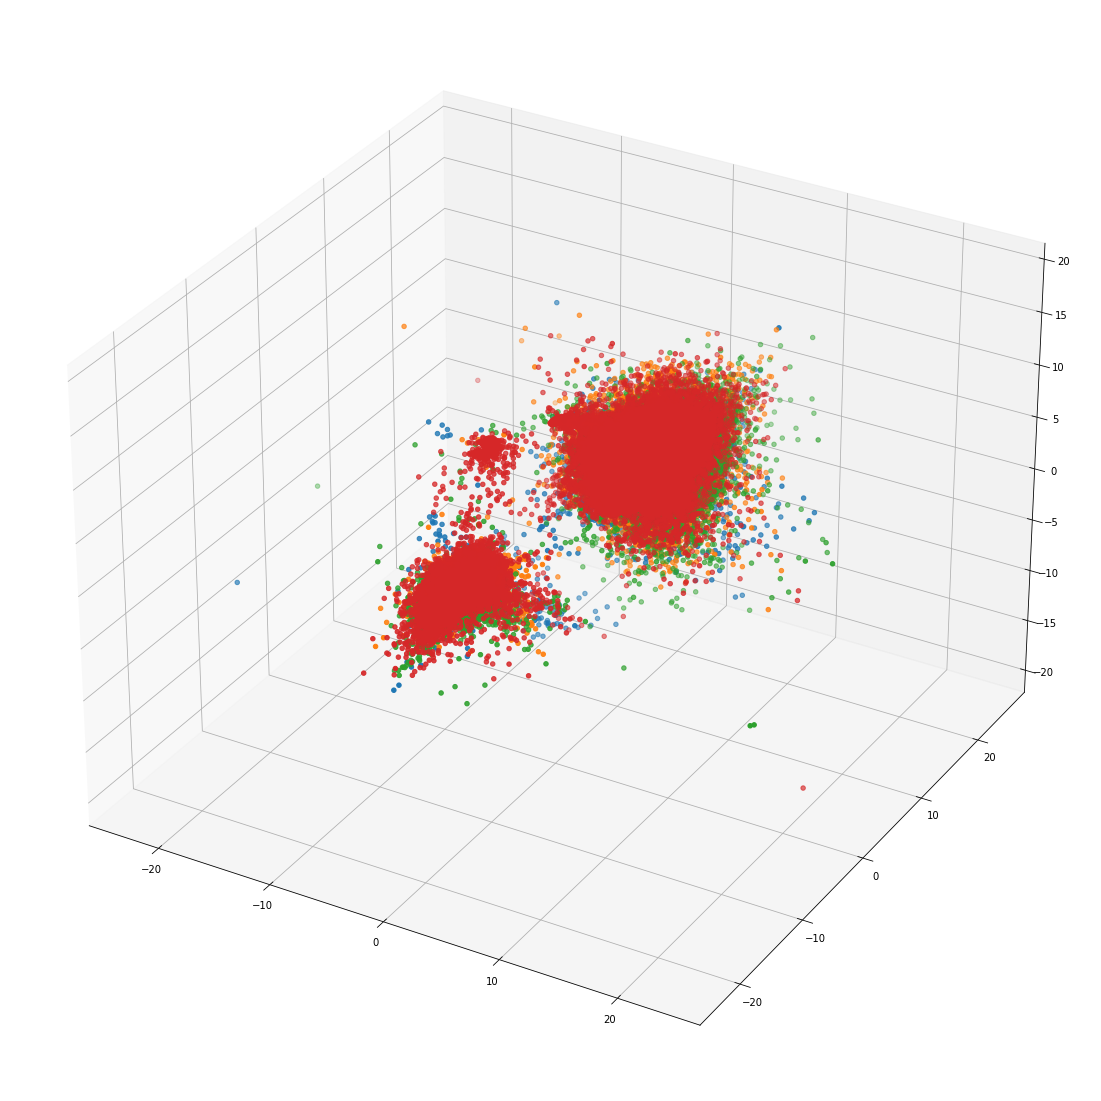

In [249]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter3D(array[:,1], array[:,2], array[:,3], "blue")
colours = ["red", "brown", "yellow", "green", "black", "purple"]

for i in range(k):
    ax.scatter3D(array[:,1][ind[i]], array[:,2][ind[i]], array[:,3][ind[i]], colours[i])


## 3.8 Implementar x% de outliers (se x>d)

A primeira função dá os outliers segundo o boxplot e a sua densidade. A função substitui alguns dos pontos para prefazer x% outliers.

In [ ]:
def get_outliers(vec):
    q1 = np.quantile(vec, 0.25)
    q3 = np.quantile(vec, 0.75)
    #av = np.average(vec)
    
    iqr = q3-q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)

    outliers = vec[(vec <= lower_bound) | (vec >= upper_bound)]
    out_bool = (vec <= lower_bound) | (vec >= upper_bound)
    
    counts = np.count_nonzero(out_bool==True)
    d = (counts/out_bool.size)*100
    return outliers, np.where(out_bool), d

def inject_outliers(x, d, data, shape):
    '''
    x - percentage of outliers wanted
    d - actual deviation
    data - data to be transformed
    shape - length of the data
    '''
    index = []
    if (x>d):
        points = round((x-d)*shape*0.01)
        median = np.median(data)
        sd = np.std(data)
        s = (np.random.random()*2)-1
        rang = np.ptp(data) # range
        for i in range(points):
            q = np.random.random()*rang
            point = round(np.random.random()*(data.shape[0])-1)
            index.append(point)
            data[point] = median+s*3*(sd+q)
    return data, index


## 3.9 Determinar o modelo linear a partir de uma amostra de treino

In [ ]:
from sklearn import linear_model

def fit_linear(X, Y, n):
    '''
    X - train array (size p)
    Y - array to fit
    n - train size
    '''    
    reg = linear_model.LinearRegression()
    reg.fit(X[:n].reshape(-1,1), Y[:n])
    return reg.coef_

## 3.10 Injetar outliers e modelar linearmente

In [ ]:
x = 10
t_out, t_ind, td = get_outliers(t_acc)
t_outliers, indexes = inject_outliers(x, td, t_acc.copy(), t_acc.shape[0])


Retirar os índices dos outliers e substituir os valores pelos previstos no modelo:

In [252]:
coef = []

# amostra de treino
n = t_acc.size    
ran = np.ptp(t_acc)
train = np.random.rand(n,2)*ran
train = np.append(train[:n], train[:n])

# vetor indices e substituicao dos valores
index = np.rint(np.hstack((t_ind[0], indexes))).astype(int)
coef = fit_linear(train, t_outliers, n)
t_outliers[index] = train[index]*coef

# 4. Extração de informação caraterística

[Implementing Feature Selection Methods for ML](https://ranasinghiitkgp.medium.com/implementing-feature-selection-methods-for-machine-learning-bfa2e4b4e02)

## 4.1 Significância e gaussianidade

In [261]:
from scipy import stats

mean = []
ks_test = []

for box in ([box_acc, box_gyr, box_mag]):
    for i in range(16):
        mean.append(np.mean(box[:][i]))
        ks_test.append(stats.kstest(box[:][i], 'norm'))
        print("ks value for the activity {}: {}".format(i, ks_test[-1][0]))


ks value for the activity 0: 0.9999999988203478
ks value for the activity 1: 0.9189320835352807
ks value for the activity 2: 0.9848861413307427
ks value for the activity 3: 0.9997848772028269
ks value for the activity 4: 0.999896693089915
ks value for the activity 5: 0.9991919884219767
ks value for the activity 6: 0.9984629683581309
ks value for the activity 7: 0.9452111215384591
ks value for the activity 8: 0.9967472382781719
ks value for the activity 9: 0.9820698772746062
ks value for the activity 10: 0.9903609951342658
ks value for the activity 11: 0.9999999997183068
ks value for the activity 12: 0.9999999999999982
ks value for the activity 13: 0.9999964749540581
ks value for the activity 14: 0.9999559046157585
ks value for the activity 15: 0.9999949764648844
ks value for the activity 0: 0.552295211723606
ks value for the activity 1: 0.5148263033571472
ks value for the activity 2: 0.5263880019997702
ks value for the activity 3: 0.9681553332697119
ks value for the activity 4: 0.97514

## 4.2 Extração de *features* relevantes

No artigo em causa, as features estatísticas direcionam-se apenas a cada eixo do acelerómetro e do giroscópio (colunas 1-7)

Damos também uso à estratégia 'sliding window' para atuar em todo o array de forma contínua

In [ ]:
time = array[:,-2]
delta_time = time[1] - time[0]
deci = (2/0.60)*1000
window = math.floor(deci/delta_time)
print("window length: {}".format(window))

window length: 170


Não se realizam os testes de 'Pairwise Correlation', 'Averaged Velocity along Heading Direction' e de 'Averaged Velocity along Gravity Direction' devido à dificuldade de buscar os valores pretendidos para os cálculos.

In [269]:
# acceleroemeter and gyroscope
mean = featuresFunctions.mean(array[:,1:7], window)
median = featuresFunctions.median(array[:,1:7], window)
std, var = featuresFunctions.std_var(array[:,1:7], window)
rms = featuresFunctions.rms(array[:,1:7], window)
skew = featuresFunctions.skewness(array[:,1:7], window)
kurt = featuresFunctions.kurtosis(array[:,1:7], window)
irange = featuresFunctions.irange(array[:,1:7], window)
zcr = featuresFunctions.zero_crossing_rate(array[:,1:7], window)
mcr = featuresFunctions.mean_crossing_rate(array[:,1:7], window)

ai, vi = featuresFunctions.mov_intensity(t_acc, window) # acceleration axis
sma = featuresFunctions.sma(array[:,1:4], window) # acceleration axis
eva = featuresFunctions.eva(array[:,1:4], window) # acceleration axis
cagh = featuresFunctions.cagh(array[:,2], array[:,3], array[:,1], window) # acceleration axis
domf, ener, aae, are = featuresFunctions.df_energy_aae_are(array[:,1:7], window) # each axis

2555.406
2462.0164999999997
2459.5031
2438.0191999999997
2438.8818
2417.271
2441.9012000000002
2421.842
2433.8311999999996
2430.8394999999996
2436.8916
2461.48377
2483.6605
2489.0765
2494.3194000000003
2310.6823225
2193.34343
2166.11317
2159.2390299999997
2136.77827
2124.85803
2123.42016
2122.18691
2120.3389
2122.8791
2126.31034
2121.48364
2118.37588
2116.08092
2111.6212699999996
2105.1938500000006
2097.73509
2100.67231
2101.3460920099997
2075.7039044800003
2065.0545485400003
2066.3359652400004
2065.98332787
2067.7178004400002
2067.3192
2065.74154657
2065.92453698
2070.61453462
2068.6462575799997
2061.7730867
2059.73216454
2061.0751802899995
2063.49909319
2061.67467966
2063.44387501
2063.2214273199997
2338.8439326000002
2462.5686
2457.2740999999996
2444.6143
2441.4753
2447.0480000000002
2420.8205000000007
2418.7156
2408.5465
2227.684166457
2067.4461904000004
2060.17647
2072.7081313999997
2080.917396
2084.110314
2075.779181
2071.88875104
2054.07010534
2057.0520685700003
2082.65325442000

In [271]:
feat_array = np.concatenate((mean, median, std, var, rms, irange,\
    zcr, mcr, ai, vi, sma, eva, cagh, domf, ener, aae, are), axis=1)
feat_array = abs(feat_array).astype('float64')

Ajustar as atividades ao shape[0] do novo feat_array. Isto é feito através da extração da atividade predominante em cada *window*.

In [272]:
feat_act = []
act = array[:,-1]

for i in range(round(act.shape[0]/window)):
    i*=window
    unique, counts = np.unique(act[i:(i+window)], return_counts=True)
    feat_act.append(unique[np.argmax(unique)])

feat_act = np.array(feat_act)
feat_act.shape

(4599,)

!A função que devolve o vetor *features* em cada instante é incluido no ponto 4.6.1.)

## 4.3 PCA

PCA - identifica os eixos principais de variância do *dataset*. Permite explorar as variáveis chave e descobrir outliers

In [267]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca_feature(x, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state=0)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    pca = PCA()
    transformed_train = pca.fit_transform(X_train)
    transformed_test = pca.transform(X_test)

    return transformed_train, transformed_test, pca.explained_variance_ratio_, pca.singular_values_


## 4.4 Vetores principais

A partir do teste do PCA, obtemos os pesos de cada eixo principal do *dataset*, dos quais podemos inferir qual a sua relevância para 

Normalização é feita ao implementar o z-score, que devolve uma matriz com média zero e desvio padrão 0.

Devido a vários erros encontrados, referentes a valores perto do infinito e NaN, sem resolução encontrada, utilizamos apenas as features selecionadas abaixo. Sobre estas testamos todo o resto do trabalho.

In [274]:
feat_array = np.concatenate((mean, median, std, var, rms, irange), axis=1)
feat_array = abs(feat_array).astype('float64')
print(feat_array.shape)

x, out = zscore(feat_array, 1.5)
y, out = zscore(feat_act, 1.5)

t_train, t_test, ratio, sing = pca_feature(x, y, 0.5)
print(ratio)

n_feat = 0
sum = 0
for score in ratio:
    if sum<0.75:
        n_feat+=1
        sum+=score
    else:
        break

print("Numero de features que explica 0.75 do feature set: {}".format(n_feat))

(4599, 36)
[5.84988332e-01 1.30753320e-01 6.25159209e-02 4.63271729e-02
 4.52386293e-02 2.33935907e-02 1.98852550e-02 1.68234137e-02
 1.62391619e-02 1.44907342e-02 7.35732585e-03 6.84120715e-03
 5.20977189e-03 3.73808157e-03 3.30960330e-03 2.09981731e-03
 1.88426256e-03 1.62088456e-03 1.51568324e-03 1.20981449e-03
 1.17120796e-03 1.13785978e-03 5.64169513e-04 4.06558496e-04
 3.51446750e-04 2.96304037e-04 1.98157611e-04 1.56533628e-04
 1.11151151e-04 6.88931734e-05 4.19736911e-05 2.55026101e-05
 1.61034196e-05 9.18227269e-06 2.29529784e-06 6.77813806e-07]
Numero de features que explica 0.75 do feature set: 3


(Como os pontos são repetidos, respondemos às perguntas 4.4.1 e 4.4.2 no 4.6)

## 4.5 Implementar o Fisher Score e ReliefF

In [283]:
from skfeature.function.similarity_based import fisher_score 

def f_score(x, y):
    score = fisher_score.fisher_score(x, y, mode='rank')
    return score

fisher_score = f_score(feat_array, feat_act)
print(fisher_score)

[10 34 28  7 19  1  9 33 27  6 22 18  8 20  0  4  2 21 23 31 13  5  3 25
 12 16 30 32 26 24 14 29 35 15 11 17]


In [276]:
from ReliefF import ReliefF
import sklearn_relief as rf

def relief(x, y, feat):
      r = rf.Relief(n_features=feat)
      relief_array = r.fit_transform(x, y )
      return relief_array, r.w_


# relief_array = relief(feat_array, feat_act, 5, 10)
releif_array, relief_score = relief(feat_array, feat_act, 10)
print("(No. of tuples, No. of Columns before ReliefF) : "+str(feat_array.shape)+
      "\n(No. of tuples , No. of Columns after ReliefF) : "+str(relief_array.shape))
print(relief_score)

(No. of tuples, No. of Columns before ReliefF) : (4599, 36)
(No. of tuples , No. of Columns after ReliefF) : (4599, 10)
[ 0.46756605  0.26592624  0.48462942  2.62449123  6.65722642  2.8624332
  0.44670196  0.319982    0.4956225   2.6285845   5.68055461  4.34649937
  0.16014461  0.28030313  0.13382726  1.34788916  0.56787736  0.49677534
  0.29122362  0.85938031  0.28134739 68.78185191 43.67001905 38.7323695
  0.48740853  0.2542782   0.46224677  1.73645333  3.32470736  0.85596688
  0.23728122  0.40613945  0.26056738  4.22261294  5.66183854  6.34752349]


## 4.6 Identificar as 10 melhores features

Obtemos os índices das 10 melhores features segundo os dois algoritmos de pontuação.

In [286]:
fisher_ind = np.argpartition(fisher_score, -10)[-10:]
relief_ind = np.argpartition(relief_score, -10)[-10:]

print(np.sort(fisher_ind))
print(np.sort(relief_ind))

[ 1  2  7  8 19 26 27 28 31 32]
[ 4 10 11 21 22 23 28 33 34 35]


### 4.4.1 Como obter as features relativas a esta compressão

In [301]:
def get_feat_vec(feat_array, time, columns=None):
    try:
        if type(columns)==list:
            return feat_array[time, columns]
        else:   
            return feat_array[time,:]
    except IndexError:
        return np.empty([])

### 4.4.2 Vantages e limitações

Ao selecionar as features mais relevantes garantimos um melhor desempenho do modelo em termos da relação tempo/qualidade dos resultados. Com as features bem selecionadas e discriminadas podemos direcionar o modelo e fazer predições com maior segurança.

A grande limitação é a possível "perda" de informação que pode ser chave. Com uma menor generalização dos dados, o modelo, apesar de trabalhar mais rápido, não inclui algumas informações que poderiam garantir uma melhor segunraça na predição.